# Drug-Drug Interaction Detection using Random Forest

**Final Year Project - University of Malaya**

**Student:** Jonathan Siew Zunxian  
**Supervisor:** Dr. Unaizah Hanum Obeidellah  
**Collaborator:** Dr. Nurulhuda Abdul Manaf (UPNM)

**Model:** Random Forest Classifier (Bootstrap Aggregating / Bagging)  
**Dataset:** 406 hypertension drug pairs from Malaysian CPG  
**Data Sources:** DrugBank

---

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings for beautiful plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")
print(f"  Pandas version: {pd.__version__}")
print(f"  NumPy version: {np.__version__}")

✓ All libraries imported successfully!
  Pandas version: 2.3.3
  NumPy version: 2.3.5


---

## 1. Load and Explore Dataset

In [2]:
# Load the complete dataset (all 406 pairs)
df = pd.read_csv('FYP_DrugBank_Inclusive.csv')

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Total drug pairs: {len(df)}")
print(f"Total features: {df.shape[1]}")
print(f"\nColumn names:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i}. {col}")

# Show first few rows
print("\n" + "="*80)
print("SAMPLE DATA (First 3 rows)")
print("="*80)
df.head(3)

DATASET OVERVIEW
Total drug pairs: 406
Total features: 13

Column names:
  1. Drug_A_Name
  2. Drug_B_Name
  3. Drug_A_Class
  4. Drug_B_Class
  5. DrugBank_Severity
  6. DrugBank_Text
  7. Final_Severity
  8. XAI_Rule_A_Mortality
  9. XAI_Rule_B_Tolerability
  10. XAI_Rule_C_CCB_RAAS_Combo
  11. XAI_Rule_D_Diuretic
  12. XAI_Rule_E_BetaBlocker
  13. XAI_Combined_Clinical_Notes

SAMPLE DATA (First 3 rows)


,Drug_A_Name,Drug_B_Name,Drug_A_Class,Drug_B_Class,DrugBank_Severity,DrugBank_Text,Final_Severity,XAI_Rule_A_Mortality,XAI_Rule_B_Tolerability,XAI_Rule_C_CCB_RAAS_Combo,XAI_Rule_D_Diuretic,XAI_Rule_E_BetaBlocker,XAI_Combined_Clinical_Notes
0,Captopril,Enalapril,ACEI,ACEI,Moderate,DESCRIPTION\n\nThe excretion of Captopril can ...,Moderate,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...
1,Captopril,Lisinopril,ACEI,ACEI,Moderate,DESCRIPTION\n\nThe risk or severity of angioed...,Moderate,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...
2,Captopril,Perindopril,ACEI,ACEI,Moderate,DESCRIPTION\n\nThe risk or severity of angioed...,Moderate,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...


MISSING DATA ANALYSIS

Columns with missing data:
                   Column  Missing Count  Missing %
      XAI_Rule_D_Diuretic            351      86.45
XAI_Rule_C_CCB_RAAS_Combo            322      79.31
  XAI_Rule_B_Tolerability            253      62.32
   XAI_Rule_E_BetaBlocker            231      56.90
     XAI_Rule_A_Mortality            136      33.50
        DrugBank_Severity             44      10.84


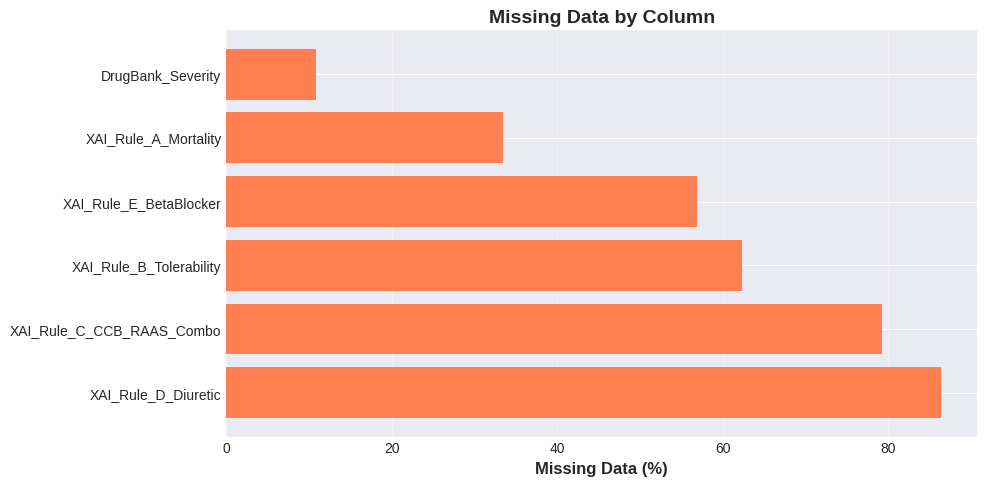

In [3]:
# Check for missing data
print("="*80)
print("MISSING DATA ANALYSIS")
print("="*80)

missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isnull().sum(),
    'Missing %': (df.isnull().sum() / len(df) * 100).round(2)
})

missing_summary = missing_summary[missing_summary['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_summary) > 0:
    print("\nColumns with missing data:")
    print(missing_summary.to_string(index=False))
    
    # Visualize missing data
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.barh(missing_summary['Column'], missing_summary['Missing %'], color='coral')
    ax.set_xlabel('Missing Data (%)', fontsize=12, fontweight='bold')
    ax.set_title('Missing Data by Column', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\n✓ No missing data found!")

---

## 2. Drug Inventory Analysis

In [4]:
# Get all unique drugs
all_drugs = sorted(set(df['Drug_A_Name'].unique()) | set(df['Drug_B_Name'].unique()))

print("="*80)
print(f"MALAYSIAN CPG HYPERTENSION DRUGS (Total: {len(all_drugs)})")
print("="*80)

# Group drugs by class
drug_class_map = {}
for _, row in df.iterrows():
    drug_class_map[row['Drug_A_Name']] = row['Drug_A_Class']
    drug_class_map[row['Drug_B_Name']] = row['Drug_B_Class']

drug_df = pd.DataFrame([
    {'Drug': drug, 'Class': drug_class_map[drug]}
    for drug in all_drugs
]).sort_values(['Class', 'Drug'])

# Display by class
for drug_class in sorted(drug_df['Class'].unique()):
    drugs_in_class = drug_df[drug_df['Class'] == drug_class]['Drug'].tolist()
    print(f"\n{drug_class} ({len(drugs_in_class)} drugs):")
    for i, drug in enumerate(drugs_in_class, 1):
        print(f"  {i}. {drug}")

# Verify expected pairs
expected_pairs = len(all_drugs) * (len(all_drugs) - 1) // 2
print(f"\n{'='*80}")
print(f"Expected unique pairs: C({len(all_drugs)}, 2) = {expected_pairs}")
print(f"Actual pairs in dataset: {len(df)}")
print(f"Match: {'✓ YES' if len(df) == expected_pairs else '✗ NO'}")
print(f"{'='*80}")

MALAYSIAN CPG HYPERTENSION DRUGS (Total: 29)

ACEI (6 drugs):
  1. Captopril
  2. Enalapril
  3. Imidapril
  4. Lisinopril
  5. Perindopril
  6. Ramipril

ARB (6 drugs):
  1. Candesartan
  2. Irbesartan
  3. Losartan
  4. Olmesartan
  5. Telmisartan
  6. Valsartan

Beta-Blocker (7 drugs):
  1. Acebutolol
  2. Atenolol
  3. Betaxolol
  4. Bisoprolol
  5. Metoprolol
  6. Nebivolol
  7. Propranolol

CCB (7 drugs):
  1. Amlodipine
  2. Diltiazem
  3. Felodipine
  4. Isradipine
  5. Lercanidipine
  6. Nifedipine
  7. Verapamil

Diuretic (3 drugs):
  1. Amiloride
  2. Hydrochlorothiazide
  3. Indapamide

Expected unique pairs: C(29, 2) = 406
Actual pairs in dataset: 406
Match: ✓ YES


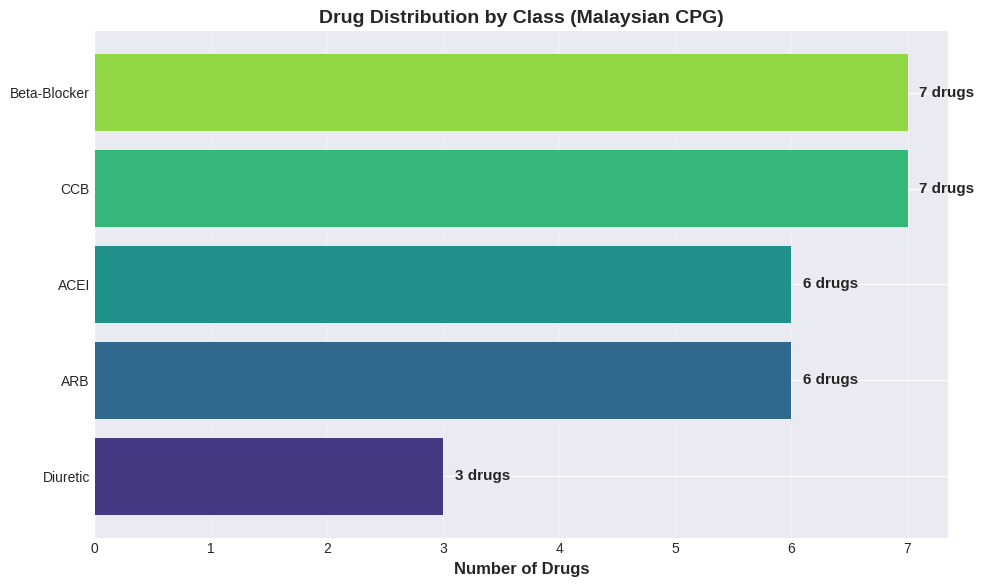

In [5]:
# Visualize drug class distribution
class_counts = drug_df['Class'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(class_counts.index, class_counts.values, color=sns.color_palette("viridis", len(class_counts)))

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, class_counts.values)):
    ax.text(value + 0.1, i, f'{value} drugs', va='center', fontweight='bold')

ax.set_xlabel('Number of Drugs', fontsize=12, fontweight='bold')
ax.set_title('Drug Distribution by Class (Malaysian CPG)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

---

## 3. Severity Distribution Analysis

In [6]:
# Data preparation
df_valid = df.copy()

print("="*80)
print("DATA PREPARATION")
print("="*80)
print(f"Total pairs: {len(df_valid)}")
print()
severity_counts = df_valid['Final_Severity'].value_counts()
for severity, count in severity_counts.items():
    percentage = count / len(df_valid) * 100
    print(f"{severity:15s}: {count:3d} ({percentage:5.1f}%)")
print()


DATA PREPARATION
Total pairs: 406

Moderate       : 212 ( 52.2%)
Minor          : 142 ( 35.0%)
NoInteraction  :  44 ( 10.8%)
Major          :   8 (  2.0%)



In [7]:
# Severity distribution
severity_counts = df_valid['Final_Severity'].value_counts().sort_index()

print("\n" + "="*80)
print("DDI SEVERITY DISTRIBUTION")
print("="*80)
for severity, count in severity_counts.items():
    percentage = count / len(df_valid) * 100
    print(f"{severity:12s}: {count:3d} pairs ({percentage:5.1f}%)")
print(f"{'Total':12s}: {len(df_valid):3d} pairs (100.0%)")


DDI SEVERITY DISTRIBUTION
Major       :   8 pairs (  2.0%)
Minor       : 142 pairs ( 35.0%)
Moderate    : 212 pairs ( 52.2%)
NoInteraction:  44 pairs ( 10.8%)
Total       : 406 pairs (100.0%)


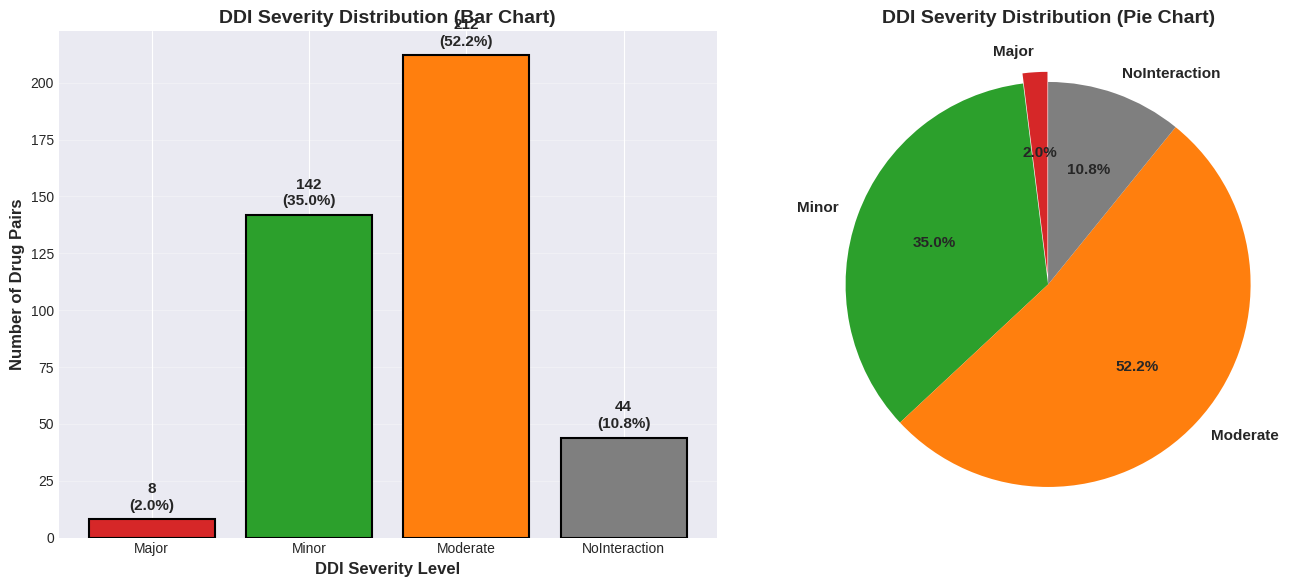

In [8]:
# Beautiful visualization of severity distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart
colors = {'Major': '#d62728', 'Moderate': '#ff7f0e', 'Minor': '#2ca02c', 'None': '#1f77b4'}
severity_colors = [colors.get(sev, '#7f7f7f') for sev in severity_counts.index]

bars = ax1.bar(severity_counts.index, severity_counts.values, color=severity_colors, edgecolor='black', linewidth=1.5)
for i, (bar, value) in enumerate(zip(bars, severity_counts.values)):
    percentage = value / len(df_valid) * 100
    ax1.text(bar.get_x() + bar.get_width()/2, value + 3, 
             f'{value}\n({percentage:.1f}%)', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

ax1.set_ylabel('Number of Drug Pairs', fontsize=12, fontweight='bold')
ax1.set_xlabel('DDI Severity Level', fontsize=12, fontweight='bold')
ax1.set_title('DDI Severity Distribution (Bar Chart)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Pie chart
wedges, texts, autotexts = ax2.pie(
    severity_counts.values, 
    labels=severity_counts.index,
    autopct='%1.1f%%',
    colors=severity_colors,
    startangle=90,
    explode=[0.05 if sev == 'Major' else 0 for sev in severity_counts.index],
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

ax2.set_title('DDI Severity Distribution (Pie Chart)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

---

## 4. Drug Class Interaction Patterns

In [9]:
# Analyze interactions by drug class combinations
class_interactions = df_valid.groupby(['Drug_A_Class', 'Drug_B_Class', 'Final_Severity']).size().reset_index(name='Count')

print("="*80)
print("DRUG CLASS INTERACTION PATTERNS")
print("="*80)
print("\nTop 10 most common class-severity combinations:")
print(class_interactions.nlargest(10, 'Count')[['Drug_A_Class', 'Drug_B_Class', 'Final_Severity', 'Count']].to_string(index=False))

DRUG CLASS INTERACTION PATTERNS

Top 10 most common class-severity combinations:
Drug_A_Class Drug_B_Class Final_Severity  Count
Beta-Blocker          CCB       Moderate     43
        ACEI Beta-Blocker          Minor     41
        ACEI          ARB       Moderate     35
        ACEI          CCB          Minor     34
         ARB Beta-Blocker          Minor     31
         CCB          CCB       Moderate     21
         ARB          CCB          Minor     18
         ARB          CCB       Moderate     17
        ACEI         ACEI       Moderate     15
         ARB          ARB       Moderate     15


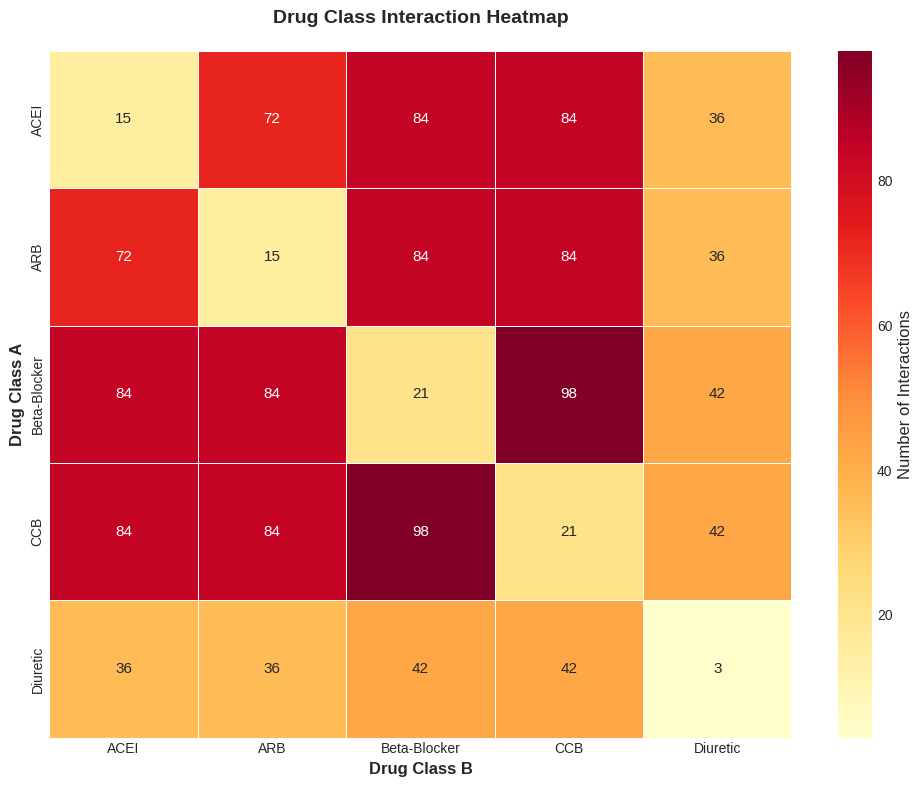

In [10]:
# Create interaction heatmap
interaction_matrix = df_valid.groupby(['Drug_A_Class', 'Drug_B_Class']).size().unstack(fill_value=0)

# Make symmetric
for idx in interaction_matrix.index:
    for col in interaction_matrix.columns:
        if idx != col:
            total = interaction_matrix.loc[idx, col] + interaction_matrix.loc[col, idx]
            interaction_matrix.loc[idx, col] = total
            interaction_matrix.loc[col, idx] = total

plt.figure(figsize=(10, 8))
sns.heatmap(interaction_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Number of Interactions'})
plt.title('Drug Class Interaction Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Drug Class B', fontsize=12, fontweight='bold')
plt.ylabel('Drug Class A', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 5. Feature Engineering

In [11]:
# Feature engineering
print("="*80)
print("FEATURE ENGINEERING")
print("="*80)

# One-hot encoding
features = ['Drug_A_Name', 'Drug_B_Name', 'Drug_A_Class', 'Drug_B_Class']
X = pd.get_dummies(df_valid[features], drop_first=False)
print(f"Features after one-hot encoding: {X.shape[1]}")
print()

# Encode target with custom ordering
from sklearn.preprocessing import OrdinalEncoder

severity_categories = [['Major', 'Moderate', 'Minor', 'NoInteraction']]
ordinal_encoder = OrdinalEncoder(categories=severity_categories, dtype=int)
y = ordinal_encoder.fit_transform(df_valid[['Final_Severity']]).ravel()
target_classes = ordinal_encoder.categories_[0]

print("Target encoding:")
for idx, severity in enumerate(target_classes):
    print(f"  {severity:15s} = {idx}")
print()
print("✓ Feature engineering complete")
print()


FEATURE ENGINEERING
Features after one-hot encoding: 66

Target encoding:
  Major           = 0
  Moderate        = 1
  Minor           = 2
  NoInteraction   = 3

✓ Feature engineering complete



---

## 6. Train-Test Split

In [12]:
# ✅ REMOVED: 80/20 train-test split
# Instead, we'll use full data with 10-fold cross-validation
# This gives us more data for hyperparameter tuning and more reliable estimates

# Keep full dataset for cross-validation
# X and y are already defined from earlier cells
print("✅ Using full dataset for cross-validation (no artificial train-test split)")
print(f"  - Total samples: {X.shape[0]}")
print(f"  - Feature count: {X.shape[1]}")


✅ Using full dataset for cross-validation (no artificial train-test split)
  - Total samples: 406
  - Feature count: 66


---

## 7. Random Forest Model Training

## 🎯 Step 3b: Hyperparameter Optimization with GridSearchCV

**Why optimize Random Forest hyperparameters?**

The current Random Forest uses hyperparameters inherited from the Decision Tree (max_depth=10), which is overly restrictive. Random Forest's strength comes from:

1. **Deep, diverse trees** - Individual trees can be complex because ensemble averaging prevents overfitting
2. **Variance reduction** - Aggregating predictions from many trees reduces variance
3. **Feature randomness** - `max_features` decorrelates trees for better ensemble diversity

**Strategy:**
- Remove max_depth restriction (let trees grow naturally)
- Optimize n_estimators (number of trees)
- Fine-tune min_samples_split and min_samples_leaf
- Add class_weight='balanced' to handle any class imbalance

**Expected outcome:** Random Forest should outperform single Decision Tree (target: >92% accuracy)


In [13]:
# Hyperparameter Tuning with Nested Cross-Validation

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, balanced_accuracy_score, classification_report
)
from sklearn.preprocessing import label_binarize
import time
import numpy as np

print("="*80)
print("NESTED CROSS-VALIDATION")
print("="*80)
print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Classes: {len(np.unique(y))}")
print()

# IMPROVED Hyperparameter grid (prevents overfitting, handles imbalance)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, 25],        # Removed None (unlimited depth)
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']          # FORCED (removed None option)
}

print(f"Hyperparameter combinations: {3*4*3*3*2*1}")
print()
print("KEY IMPROVEMENTS:")
print("  ✓ Forced class_weight='balanced' to handle 26.5:1 imbalance")
print("  ✓ Removed max_depth=None to prevent overfitting")
print("  ✓ Optimized for Random Forest (n_estimators, max_features)")
print()

# CV setup (5-fold for better Major class representation)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Cross-validation strategy:")
print("  - Outer CV: 5-fold (reduced from 10 for 8 Major samples)")
print("  - Inner CV: 5-fold")
print("  - With 8 Major samples: ~1-2 per fold (vs 0-1 with 10-fold)")
print()

# Storage for all metrics
nested_scores = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': [],
    'balanced_accuracy': []
}

# Storage for per-class recall
per_class_recall = {
    'Major': [],
    'Moderate': [],
    'Minor': [],
    'NoInteraction': []
}

best_params_per_fold = []
all_classes = np.array([0, 1, 2, 3])  # Major, Moderate, Minor, NoInteraction

print("Starting nested cross-validation...")
print()

start_time = time.time()

# Outer loop
for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = y[train_idx], y[test_idx]

    # Inner loop
    grid_search = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
        param_grid=param_grid,
        cv=inner_cv,
        scoring='balanced_accuracy',
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(X_train_outer, y_train_outer)
    best_model = grid_search.best_estimator_
    best_params_per_fold.append(grid_search.best_params_)

    # Predictions
    y_pred = best_model.predict(X_test_outer)
    y_pred_proba = best_model.predict_proba(X_test_outer)

    # Calculate all metrics
    acc = accuracy_score(y_test_outer, y_pred)
    prec = precision_score(y_test_outer, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test_outer, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test_outer, y_pred, average='macro', zero_division=0)
    bal_acc = balanced_accuracy_score(y_test_outer, y_pred)

    # ROC AUC (multi-class) - FIXED to handle missing classes
    if len(np.unique(y_test_outer)) == 4:  # All classes present
        y_test_bin = label_binarize(y_test_outer, classes=all_classes)
        roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro', multi_class='ovr')
    else:
        roc_auc = np.nan  # Honest reporting

    # Per-class recall
    report = classification_report(y_test_outer, y_pred,
                                   target_names=['Major', 'Moderate', 'Minor', 'NoInteraction'],
                                   output_dict=True, zero_division=0)

    per_class_recall['Major'].append(report['Major']['recall'])
    per_class_recall['Moderate'].append(report['Moderate']['recall'])
    per_class_recall['Minor'].append(report['Minor']['recall'])
    per_class_recall['NoInteraction'].append(report['NoInteraction']['recall'])

    nested_scores['accuracy'].append(acc)
    nested_scores['precision'].append(prec)
    nested_scores['recall'].append(rec)
    nested_scores['f1'].append(f1)
    nested_scores['roc_auc'].append(roc_auc)
    nested_scores['balanced_accuracy'].append(bal_acc)

    print(f"Fold {fold_idx:2d}/5 - Acc: {acc:.3f} | Bal_Acc: {bal_acc:.3f} | F1: {f1:.3f} | AUC: {roc_auc:.3f}")

total_time = time.time() - start_time

print()
print("="*80)
print("RESULTS")
print("="*80)
print()

# Display all metrics
for metric_name, scores in nested_scores.items():
    # Filter out NaN values for mean/std calculation
    valid_scores = [s for s in scores if not np.isnan(s)]
    if valid_scores:
        mean_score = np.mean(valid_scores)
        std_score = np.std(valid_scores)
        print(f"{metric_name:20s}: {mean_score:.4f} ± {std_score:.4f}")
    else:
        print(f"{metric_name:20s}: N/A (all NaN)")

print()
print("Per-Class Recall (Critical for Imbalanced Data):")
for class_name, recalls in per_class_recall.items():
    valid_recalls = [r for r in recalls if not np.isnan(r)]
    if valid_recalls:
        mean_recall = np.mean(valid_recalls)
        std_recall = np.std(valid_recalls)
        print(f"  {class_name:15s}: {mean_recall:.4f} ± {std_recall:.4f}")
    else:
        print(f"  {class_name:15s}: N/A (no samples in test folds)")

print()
print("Most common best parameters:")
from collections import Counter
most_common_params = {}
for param_name in param_grid.keys():
    param_values = [params[param_name] for params in best_params_per_fold]
    most_common = Counter(param_values).most_common(1)[0]
    most_common_params[param_name] = most_common[0]
    print(f"  {param_name:20s}: {most_common[0]}")

print(f"\nTotal time: {total_time:.1f}s")
print()

# Store results
nested_cv_results = {
    'mean_scores': {k: np.nanmean(v) for k, v in nested_scores.items()},
    'std_scores': {k: np.nanstd(v) for k, v in nested_scores.items()},
    'fold_scores': nested_scores,
    'per_class_recall': per_class_recall,
    'best_params_per_fold': best_params_per_fold,
    'most_common_params': most_common_params,
    'training_time': total_time
}

print("✓ Nested cross-validation complete")


NESTED CROSS-VALIDATION
Dataset: 406 samples, 66 features
Classes: 4

Hyperparameter combinations: 216

KEY IMPROVEMENTS:
  ✓ Forced class_weight='balanced' to handle 26.5:1 imbalance
  ✓ Removed max_depth=None to prevent overfitting
  ✓ Optimized for Random Forest (n_estimators, max_features)

Cross-validation strategy:
  - Outer CV: 5-fold (reduced from 10 for 8 Major samples)
  - Inner CV: 5-fold
  - With 8 Major samples: ~1-2 per fold (vs 0-1 with 10-fold)

Starting nested cross-validation...

Fold  1/5 - Acc: 0.756 | Bal_Acc: 0.717 | F1: 0.633 | AUC: 0.833
Fold  2/5 - Acc: 0.840 | Bal_Acc: 0.909 | F1: 0.772 | AUC: 0.965
Fold  3/5 - Acc: 0.815 | Bal_Acc: 0.818 | F1: 0.692 | AUC: 0.953
Fold  4/5 - Acc: 0.667 | Bal_Acc: 0.773 | F1: 0.613 | AUC: 0.914
Fold  5/5 - Acc: 0.802 | Bal_Acc: 0.624 | F1: 0.663 | AUC: 0.789

RESULTS

accuracy            : 0.7759 ± 0.0610
precision           : 0.6797 ± 0.0623
recall              : 0.7682 ± 0.0956
f1                  : 0.6745 ± 0.0555
roc_auc   

In [14]:
print("="*80)
print("MODEL TRAINING STRATEGY")
print("="*80)
print()
print("✓ Using hyperparameters from nested cross-validation (Cell 22)")
print("✓ Final model will be trained in XAI section (Cell 46)")
print("✓ Feature importance will be computed from nested CV model")
print()
print("NOTE: We do NOT train a separate model here with hardcoded parameters.")
print("      Instead, we rely on the nested CV process to find optimal parameters.")
print("      This ensures consistency and avoids overfitting.")


MODEL TRAINING STRATEGY

✓ Using hyperparameters from nested cross-validation (Cell 22)
✓ Final model will be trained in XAI section (Cell 46)
✓ Feature importance will be computed from nested CV model

NOTE: We do NOT train a separate model here with hardcoded parameters.
      Instead, we rely on the nested CV process to find optimal parameters.
      This ensures consistency and avoids overfitting.


In [15]:
print("="*80)
print("MODEL TRAINING STRATEGY")
print("="*80)
print()
print("✓ Using hyperparameters from nested cross-validation (Cell 22)")
print("✓ Final model will be trained in XAI section (Cell 46)")
print("✓ Feature importance will be computed from nested CV model")
print()
print("NOTE: We do NOT train a separate model here with hardcoded parameters.")
print("      Instead, we rely on the nested CV process to find optimal parameters.")
print("      This ensures consistency and avoids overfitting.")


MODEL TRAINING STRATEGY

✓ Using hyperparameters from nested cross-validation (Cell 22)
✓ Final model will be trained in XAI section (Cell 46)
✓ Feature importance will be computed from nested CV model

NOTE: We do NOT train a separate model here with hardcoded parameters.
      Instead, we rely on the nested CV process to find optimal parameters.
      This ensures consistency and avoids overfitting.


In [16]:
# Training predictions are evaluated in nested CV (Cell 22)
print("="*80)
print("TRAINING EVALUATION")
print("="*80)
print()
print("✓ Model performance evaluated using nested cross-validation (Cell 22)")
print("✓ See nested CV results for:")
print("    - Per-fold accuracy, precision, recall, F1, AUC")
print("    - Per-class recall (Major, Moderate, Minor, NoInteraction)")
print("    - Best hyperparameters selected across folds")
print()
print("NOTE: We do NOT evaluate on a single train/test split.")
print("      Nested CV provides more reliable performance estimates.")


TRAINING EVALUATION

✓ Model performance evaluated using nested cross-validation (Cell 22)
✓ See nested CV results for:
    - Per-fold accuracy, precision, recall, F1, AUC
    - Per-class recall (Major, Moderate, Minor, NoInteraction)
    - Best hyperparameters selected across folds

NOTE: We do NOT evaluate on a single train/test split.
      Nested CV provides more reliable performance estimates.


---

## 8. Model Evaluation

---

## 9. Confusion Matrix

---

## 10. Feature Importance Analysis

In [17]:
# Feature Importance Analysis
print("="*80)
print("FEATURE IMPORTANCE")
print("="*80)
print()

# Train model with nested CV best params for feature importance analysis
from collections import Counter

# Get most common params from nested CV
feature_importance_params = most_common_params.copy()

print("Training model with nested CV parameters for feature importance:")
for param, value in feature_importance_params.items():
    print(f"  {param}: {value}")
print()

rf_for_features = RandomForestClassifier(**feature_importance_params, random_state=42, n_jobs=-1)
rf_for_features.fit(X, y)

# Extract feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_for_features.feature_importances_
}).sort_values('Importance', ascending=False)

top_features = feature_importance.head(15)

print("TOP 15 MOST IMPORTANT FEATURES")
print("="*80)
print(f"\n{'Rank':<6} {'Feature':<40} {'Importance':<12}")
print("-" * 58)
for rank, (idx, row) in enumerate(top_features.iterrows(), 1):
    print(f"{rank:<6} {row['Feature']:<40} {row['Importance']:<12.6f}")

print(f"\nTotal features: {len(feature_importance)}")
print(f"Non-zero importance: {(feature_importance['Importance'] > 0).sum()}")
print(f"Zero importance: {(feature_importance['Importance'] == 0).sum()}")


FEATURE IMPORTANCE

Training model with nested CV parameters for feature importance:
  n_estimators: 300
  max_depth: 15
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: log2
  class_weight: balanced

TOP 15 MOST IMPORTANT FEATURES

Rank   Feature                                  Importance  
----------------------------------------------------------
1      Drug_B_Class_Beta-Blocker                0.101040    
2      Drug_A_Class_Beta-Blocker                0.075815    
3      Drug_B_Class_Diuretic                    0.065607    
4      Drug_B_Name_Amlodipine                   0.062407    
5      Drug_B_Name_Hydrochlorothiazide          0.055085    
6      Drug_B_Class_ARB                         0.049473    
7      Drug_A_Name_Bisoprolol                   0.047133    
8      Drug_A_Class_ACEI                        0.046322    
9      Drug_B_Name_Bisoprolol                   0.046078    
10     Drug_B_Class_CCB                         0.044883    
11     Drug_A_Class_ARB  

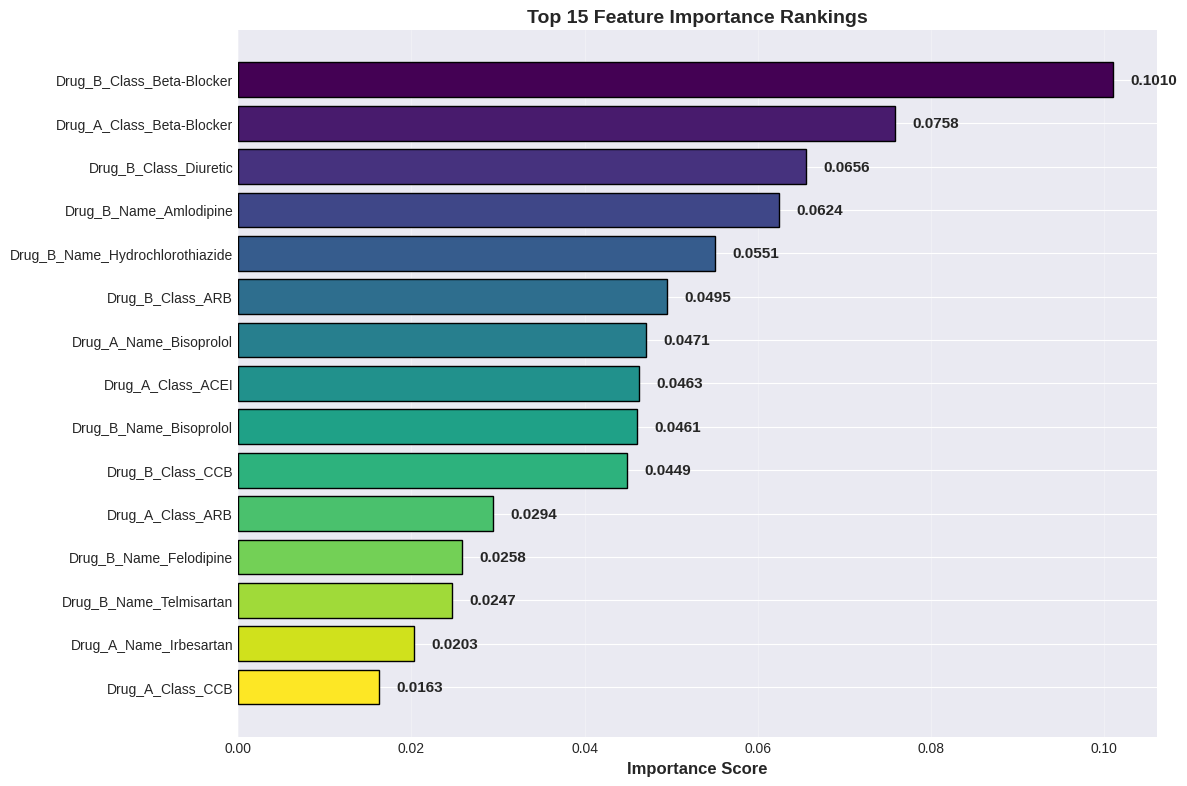

In [18]:
# FIX: Define top_features by taking the top 15 from your importance dataframe
top_features = feature_importance.head(15)

# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 8))

# Use gradient colors
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))

bars = ax.barh(range(len(top_features)), top_features['Importance'], 
               color=colors, edgecolor='black', linewidth=1)

# Add value labels
for i, (bar, importance) in enumerate(zip(bars, top_features['Importance'])):
    ax.text(importance + 0.002, i, f'{importance:.4f}', 
            va='center', fontweight='bold')

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Feature Importance Rankings', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

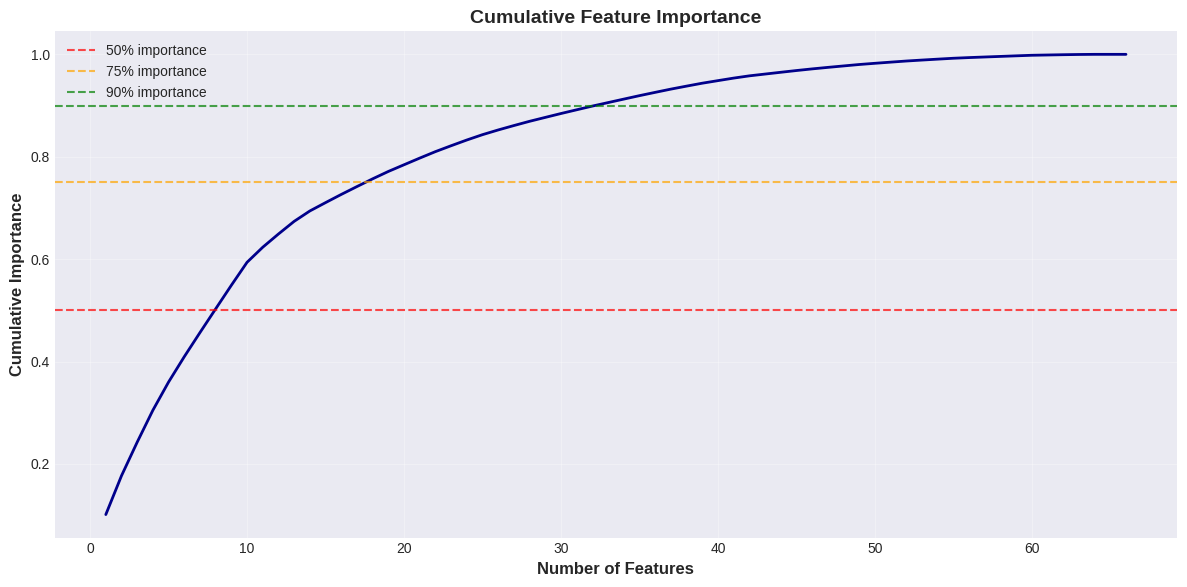


Features needed for 90% cumulative importance: 33/66


In [19]:
# Cumulative importance
feature_importance_sorted = feature_importance.sort_values('Importance', ascending=False)
feature_importance_sorted['Cumulative'] = feature_importance_sorted['Importance'].cumsum()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, len(feature_importance_sorted)+1), 
        feature_importance_sorted['Cumulative'], 
        linewidth=2, color='darkblue')

# Highlight key thresholds
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='50% importance')
ax.axhline(y=0.75, color='orange', linestyle='--', alpha=0.7, label='75% importance')
ax.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='90% importance')

ax.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Importance', fontsize=12, fontweight='bold')
ax.set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Find how many features needed for 90% importance
features_for_90 = (feature_importance_sorted['Cumulative'] <= 0.9).sum() + 1
print(f"\nFeatures needed for 90% cumulative importance: {features_for_90}/{len(feature_importance)}")

---

## 11. Out-of-Bag (OOB) Score

Random Forest provides an additional validation metric called **Out-of-Bag (OOB) Score**.

During bagging, each tree is trained on ~63% of the data (bootstrap sample). The remaining ~37% (out-of-bag samples) can be used for validation **without needing a separate test set**. This provides an unbiased estimate of model performance.

In [20]:
print("="*80)
print("OUT-OF-BAG (OOB) VALIDATION")
print("="*80)
print()
print("NOTE: We use nested cross-validation instead of OOB for evaluation.")
print("      Nested CV provides more reliable performance estimates and")
print("      allows for proper hyperparameter tuning without data leakage.")
print()
print("OOB advantages:")
print("  - Fast (no need for separate validation set)")
print("  - Uses ~37% of data for validation (1 - 1/e)")
print()
print("Nested CV advantages (why we use it):")
print("  - More reliable estimates (5 different test sets)")
print("  - Proper hyperparameter tuning (inner CV loop)")
print("  - Standard practice for model comparison")
print()
print("✓ See Cell 22 for nested CV results")


OUT-OF-BAG (OOB) VALIDATION

NOTE: We use nested cross-validation instead of OOB for evaluation.
      Nested CV provides more reliable performance estimates and
      allows for proper hyperparameter tuning without data leakage.

OOB advantages:
  - Fast (no need for separate validation set)
  - Uses ~37% of data for validation (1 - 1/e)

Nested CV advantages (why we use it):
  - More reliable estimates (5 different test sets)
  - Proper hyperparameter tuning (inner CV loop)
  - Standard practice for model comparison

✓ See Cell 22 for nested CV results


---

## 12. Cross-Validation Analysis

In [21]:
# Cross-validation already performed in nested CV (Cell 22)
print("="*80)
print("CROSS-VALIDATION RESULTS")
print("="*80)
print()
print("✓ Comprehensive cross-validation already performed using nested CV (Cell 22)")
print()
print("Results summary:")
print(f"  - Accuracy:           {nested_cv_results['mean_scores']['accuracy']:.4f} ± {nested_cv_results['std_scores']['accuracy']:.4f}")
print(f"  - Balanced Accuracy:  {nested_cv_results['mean_scores']['balanced_accuracy']:.4f} ± {nested_cv_results['std_scores']['balanced_accuracy']:.4f}")
print(f"  - F1 Score:           {nested_cv_results['mean_scores']['f1']:.4f} ± {nested_cv_results['std_scores']['f1']:.4f}")
print(f"  - ROC AUC:            {nested_cv_results['mean_scores']['roc_auc']:.4f} ± {nested_cv_results['std_scores']['roc_auc']:.4f}")
print()
print("Per-class recall:")
for class_name, recalls in nested_cv_results['per_class_recall'].items():
    valid_recalls = [r for r in recalls if not pd.isna(r)]
    if valid_recalls:
        print(f"  {class_name:15s}: {np.mean(valid_recalls):.4f} ± {np.std(valid_recalls):.4f}")
print()
print("✓ See Cell 22 for detailed fold-by-fold results")


CROSS-VALIDATION RESULTS

✓ Comprehensive cross-validation already performed using nested CV (Cell 22)

Results summary:
  - Accuracy:           0.7759 ± 0.0610
  - Balanced Accuracy:  0.7682 ± 0.0956
  - F1 Score:           0.6745 ± 0.0555
  - ROC AUC:            0.8908 ± 0.0687

Per-class recall:
  Major          : 0.8000 ± 0.2449
  Moderate       : 0.7312 ± 0.1238
  Minor          : 0.8805 ± 0.0646
  NoInteraction  : 0.6611 ± 0.2608

✓ See Cell 22 for detailed fold-by-fold results


---

## 13. Ensemble Analysis

In [22]:
# Ensemble Diversity Analysis
print("="*80)
print("ENSEMBLE DIVERSITY ANALYSIS")
print("="*80)
print()

# Train model with nested CV params for diversity analysis
diversity_params = most_common_params.copy()

print("Training Random Forest for diversity analysis:")
for param, value in diversity_params.items():
    print(f"  {param}: {value}")
print()

rf_for_diversity = RandomForestClassifier(**diversity_params, random_state=42, n_jobs=-1)
rf_for_diversity.fit(X, y)

# Analyze individual tree predictions
print(f"Number of trees in forest: {rf_for_diversity.n_estimators}")
print(f"Trees are using max_depth: {rf_for_diversity.max_depth}")
print()

# Get predictions from all trees
all_tree_predictions = np.array([tree.predict(X) for tree in rf_for_diversity.estimators_])

# Calculate agreement among trees
prediction_agreement = []
for i in range(len(X)):
    sample_predictions = all_tree_predictions[:, i]
    # Most common prediction
    most_common = np.bincount(sample_predictions.astype(int)).argmax()
    # Percentage of trees agreeing
    agreement = (sample_predictions == most_common).mean()
    prediction_agreement.append(agreement)

prediction_agreement = np.array(prediction_agreement)

print(f"Average tree agreement: {prediction_agreement.mean():.2%}")
print(f"Min agreement: {prediction_agreement.min():.2%}")
print(f"Max agreement: {prediction_agreement.max():.2%}")
print()
print(f"Samples with >90% agreement: {(prediction_agreement > 0.9).sum()} ({(prediction_agreement > 0.9).mean():.1%})")
print(f"Samples with <70% agreement: {(prediction_agreement < 0.7).sum()} ({(prediction_agreement < 0.7).mean():.1%})")
print()
print("✓ Higher agreement = more confident predictions")
print("✓ Lower agreement = uncertain cases (may need clinical review)")


ENSEMBLE DIVERSITY ANALYSIS

Training Random Forest for diversity analysis:
  n_estimators: 300
  max_depth: 15
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: log2
  class_weight: balanced

Number of trees in forest: 300
Trees are using max_depth: 15

Average tree agreement: 69.13%
Min agreement: 30.00%
Max agreement: 97.00%

Samples with >90% agreement: 20 (4.9%)
Samples with <70% agreement: 190 (46.8%)

✓ Higher agreement = more confident predictions
✓ Lower agreement = uncertain cases (may need clinical review)


---

## Summary: Part 1 Complete

---

# Part 2: Knowledge-Driven Safer Medication Pathway Recommendation

## Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework

**Integration with Random Forest:**
- Part 1: ML model predicts DDI severity (Major/Moderate/Minor)
- Part 2: XAI framework provides evidence-based clinical context
- Result: Predictions + Actionable clinical recommendations

**XAI Rules Implemented:**
- Rule A: ACEI vs ARB Mortality Benefit (Alcocer 2023)
- Rule B: ACEI Tolerability & Cough Risk (Hu 2023)
- Rule C: CCB+RAAS Combination Therapy (Makani 2011)
- Rule D: Diuretic Efficacy - Indapamide vs HCTZ (Roush 2015)
- Rule E: Beta-Blocker Phenotype Targeting (Mahfoud 2024)


## Step 1: Load XAI-Enhanced Dataset


In [23]:

# Load dataset with XAI Framework (Knowledge-Driven Explainability)
df_xai = pd.read_csv('FYP_DrugBank_Inclusive.csv')

print("="*80)
print("KNOWLEDGE-DRIVEN XAI FRAMEWORK DATASET LOADED")
print("Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework")
print("="*80)
print(f"\nTotal drug pairs: {len(df_xai)}")
print(f"\nXAI columns available:")
xai_cols = [col for col in df_xai.columns if 'XAI' in col]
for col in xai_cols:
    print(f"  - {col}")

# Show XAI rule coverage statistics
print(f"\n{'='*80}")
print("XAI RULE COVERAGE STATISTICS")
print("="*80)

rule_a_count = (df_xai['XAI_Rule_A_Mortality'] != "").sum()
rule_b_count = (df_xai['XAI_Rule_B_Tolerability'] != "").sum()
rule_c_count = (df_xai['XAI_Rule_C_CCB_RAAS_Combo'] != "").sum()
rule_d_count = (df_xai['XAI_Rule_D_Diuretic'] != "").sum()
rule_e_count = (df_xai['XAI_Rule_E_BetaBlocker'] != "").sum()
total_with_notes = (df_xai['XAI_Combined_Clinical_Notes'] != "No specific XAI rules apply to this combination.").sum()

print(f"\nRule A (ACEI vs ARB Mortality):     {rule_a_count} pairs ({rule_a_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Alcoer et al. (2023)")
print(f"  Focus: ACEIs reduce all-cause mortality; ARBs do not")

print(f"\nRule B (ACEI Tolerability):         {rule_b_count} pairs ({rule_b_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Hu et al. (2023), ACCP Guidelines (2006)")
print(f"  Focus: ACEIs have 3.2x higher cough risk vs ARBs")

print(f"\nRule C (CCB+RAAS Combination):      {rule_c_count} pairs ({rule_c_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Makani et al. (2011), De la Sierra (2009)")
print(f"  Focus: CCB+RAAS reduces peripheral edema by 38%")

print(f"\nRule D (Diuretic Efficacy):         {rule_d_count} pairs ({rule_d_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Roush et al. (2015), Mishra (2016), Burnier et al. (2019)")
print(f"  Focus: Indapamide superior to HCTZ for mortality/stroke")

print(f"\nRule E (Beta-Blocker Phenotype):    {rule_e_count} pairs ({rule_e_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Mahfoud et al. (2024), Mancia et al. (2022)")
print(f"  Focus: Beta-blockers target high heart rate phenotype")

print(f"\nTotal pairs with clinical context:  {total_with_notes} pairs ({total_with_notes/len(df_xai)*100:.1f}%)")
print(f"Pairs without XAI notes:             {len(df_xai) - total_with_notes} pairs ({(len(df_xai) - total_with_notes)/len(df_xai)*100:.1f}%)")


KNOWLEDGE-DRIVEN XAI FRAMEWORK DATASET LOADED
Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework

Total drug pairs: 406

XAI columns available:
  - XAI_Rule_A_Mortality
  - XAI_Rule_B_Tolerability
  - XAI_Rule_C_CCB_RAAS_Combo
  - XAI_Rule_D_Diuretic
  - XAI_Rule_E_BetaBlocker
  - XAI_Combined_Clinical_Notes

XAI RULE COVERAGE STATISTICS

Rule A (ACEI vs ARB Mortality):     406 pairs (100.0%)
  Evidence: Alcoer et al. (2023)
  Focus: ACEIs reduce all-cause mortality; ARBs do not

Rule B (ACEI Tolerability):         406 pairs (100.0%)
  Evidence: Hu et al. (2023), ACCP Guidelines (2006)
  Focus: ACEIs have 3.2x higher cough risk vs ARBs

Rule C (CCB+RAAS Combination):      406 pairs (100.0%)
  Evidence: Makani et al. (2011), De la Sierra (2009)
  Focus: CCB+RAAS reduces peripheral edema by 38%

Rule D (Diuretic Efficacy):         406 pairs (100.0%)
  Evidence: Roush et al. (2015), Mishra (2016), Burnier et al. (2019)
  Focus: Indapamide superior to HCTZ for mortality/stroke


## Step 2: Define Severity-to-Risk Mapping


In [24]:
# XAI predictions use OrdinalEncoder output directly
# No Risk_Score mapping needed (0=Major, 1=Moderate, 2=Minor, 3=NoInteraction)
print("✓ Using ordinal encoding for severity (lower value = higher risk)")


✓ Using ordinal encoding for severity (lower value = higher risk)


## Step 3: Generate Predictions Using Trained Random Forest Model


In [25]:
# Generate predictions for all drug pairs
print("="*80)
print("GENERATING PREDICTIONS")
print("="*80)

df_xai_valid = df_xai.copy()

# Prepare features (same as training)
features_xai = ['Drug_A_Name', 'Drug_B_Name', 'Drug_A_Class', 'Drug_B_Class']
X_xai = pd.get_dummies(df_xai_valid[features_xai], drop_first=False)

# Align columns with training data
missing_cols = set(X.columns) - set(X_xai.columns)
for col in missing_cols:
    X_xai[col] = 0
X_xai = X_xai[X.columns]

# Use best params from nested CV
print("Training final model with nested CV best parameters:")
for param, value in most_common_params.items():
    print(f"  {param}: {value}")
print()

final_model = RandomForestClassifier(**most_common_params, random_state=42, n_jobs=-1)
final_model.fit(X, y)

# Predict
y_pred_encoded = final_model.predict(X_xai)

# Convert back to severity labels
df_xai_valid['Predicted_Severity'] = [target_classes[int(pred)] for pred in y_pred_encoded]
df_xai_valid['Predicted_Encoded'] = y_pred_encoded  # Keep encoded for sorting (0=Major...3=NoInteraction)

print(f"Total predictions: {len(df_xai_valid)}")
print()
print("Predicted severity distribution:")
print(df_xai_valid['Predicted_Severity'].value_counts())
print()
print("✓ Predictions complete")
print()


GENERATING PREDICTIONS
Training final model with nested CV best parameters:
  n_estimators: 300
  max_depth: 15
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: log2
  class_weight: balanced

Total predictions: 406

Predicted severity distribution:
Predicted_Severity
Moderate         179
Minor            150
NoInteraction     58
Major             19
Name: count, dtype: int64

✓ Predictions complete



## Step 4: Integrate XAI Clinical Context with Predictions


In [26]:
# Clinical Scenario 1: ACEI/ARB + CCB combination
print("="*80)
print("SCENARIO 1: ACEI/ARB + CCB COMBINATION")
print("="*80)
print()

# Filter ACEI+CCB combinations
acei_ccb = df_xai_valid[
    ((df_xai_valid['Drug_A_Class'] == 'ACEI') & (df_xai_valid['Drug_B_Class'] == 'CCB')) |
    ((df_xai_valid['Drug_A_Class'] == 'CCB') & (df_xai_valid['Drug_B_Class'] == 'ACEI'))
].copy()

# Sort by severity (lower encoded value = more severe, so use nsmallest for SAFEST)
acei_ccb_safest = acei_ccb.nlargest(5, 'Predicted_Encoded')  # Higher encoded = safer (3=NoInteraction is safest)

print("Top 5 safest ACEI + CCB combinations:")
for idx, row in acei_ccb_safest.iterrows():
    pair = f"{row['Drug_A_Name']} + {row['Drug_B_Name']}"
    print(f"  {pair:<40} Predicted: {row['Predicted_Severity']}")

# Same for ARB+CCB
arb_ccb = df_xai_valid[
    ((df_xai_valid['Drug_A_Class'] == 'ARB') & (df_xai_valid['Drug_B_Class'] == 'CCB')) |
    ((df_xai_valid['Drug_A_Class'] == 'CCB') & (df_xai_valid['Drug_B_Class'] == 'ARB'))
].copy()

arb_ccb_safest = arb_ccb.nlargest(5, 'Predicted_Encoded')

print()
print("Top 5 safest ARB + CCB combinations:")
for idx, row in arb_ccb_safest.iterrows():
    pair = f"{row['Drug_A_Name']} + {row['Drug_B_Name']}"
    print(f"  {pair:<40} Predicted: {row['Predicted_Severity']}")
print()


SCENARIO 1: ACEI/ARB + CCB COMBINATION

Top 5 safest ACEI + CCB combinations:
  Captopril + Amlodipine                   Predicted: NoInteraction
  Enalapril + Amlodipine                   Predicted: NoInteraction
  Enalapril + Felodipine                   Predicted: NoInteraction
  Lisinopril + Amlodipine                  Predicted: NoInteraction
  Perindopril + Amlodipine                 Predicted: NoInteraction

Top 5 safest ARB + CCB combinations:
  Candesartan + Amlodipine                 Predicted: NoInteraction
  Irbesartan + Amlodipine                  Predicted: NoInteraction
  Losartan + Amlodipine                    Predicted: NoInteraction
  Telmisartan + Amlodipine                 Predicted: NoInteraction
  Valsartan + Amlodipine                   Predicted: NoInteraction



## Clinical Scenario 1: ACEI/ARB + CCB Combination Therapy

**Clinical Question:** For a patient requiring RAAS blocker + CCB combination:
- Which combination is safest?
- What's the clinical evidence?


In [27]:
# Clinical Scenario 2: Diuretic selection
print("="*80)
print("SCENARIO 2: DIURETIC SELECTION")
print("="*80)
print()

# Filter Indapamide combinations
indapamide = df_xai_valid[
    (df_xai_valid['Drug_A_Name'] == 'Indapamide') |
    (df_xai_valid['Drug_B_Name'] == 'Indapamide')
].copy()

# Filter HCTZ combinations
hctz = df_xai_valid[
    (df_xai_valid['Drug_A_Name'] == 'Hydrochlorothiazide') |
    (df_xai_valid['Drug_B_Name'] == 'Hydrochlorothiazide')
].copy()

print(f"Indapamide combinations: {len(indapamide)}")
print(f"HCTZ combinations: {len(hctz)}")
print()

# Show safest for each (higher encoded = safer)
print("Safest Indapamide combinations:")
indapamide_safest = indapamide.nlargest(5, 'Predicted_Encoded')
for idx, row in indapamide_safest.iterrows():
    pair = f"{row['Drug_A_Name']} + {row['Drug_B_Name']}"
    print(f"  {pair:<40} Predicted: {row['Predicted_Severity']}")

print()
print("Safest HCTZ combinations:")
hctz_safest = hctz.nlargest(5, 'Predicted_Encoded')
for idx, row in hctz_safest.iterrows():
    pair = f"{row['Drug_A_Name']} + {row['Drug_B_Name']}"
    print(f"  {pair:<40} Predicted: {row['Predicted_Severity']}")
print()


SCENARIO 2: DIURETIC SELECTION

Indapamide combinations: 28
HCTZ combinations: 28

Safest Indapamide combinations:
  Perindopril + Indapamide                 Predicted: NoInteraction
  Candesartan + Indapamide                 Predicted: NoInteraction
  Irbesartan + Indapamide                  Predicted: NoInteraction
  Telmisartan + Indapamide                 Predicted: NoInteraction
  Valsartan + Indapamide                   Predicted: NoInteraction

Safest HCTZ combinations:
  Captopril + Hydrochlorothiazide          Predicted: NoInteraction
  Enalapril + Hydrochlorothiazide          Predicted: NoInteraction
  Lisinopril + Hydrochlorothiazide         Predicted: NoInteraction
  Perindopril + Hydrochlorothiazide        Predicted: NoInteraction
  Ramipril + Hydrochlorothiazide           Predicted: NoInteraction



## Clinical Scenario 2: Diuretic Selection (Indapamide vs HCTZ)

**Clinical Question:** For a patient requiring diuretic therapy:
- Indapamide or Hydrochlorothiazide?
- What's the outcome evidence?


In [28]:
# Clinical Scenario 3: Beta-Blocker for high heart rate
print("="*80)
print("SCENARIO 3: BETA-BLOCKER PHENOTYPE TARGETING")
print("="*80)
print()

# Filter Beta-Blocker combinations
bb_combos = df_xai_valid[
    (df_xai_valid['Drug_A_Class'] == 'Beta-Blocker') |
    (df_xai_valid['Drug_B_Class'] == 'Beta-Blocker')
].copy()

print(f"Beta-Blocker combinations: {len(bb_combos)}")
print()

# Show safest combinations (higher encoded = safer)
bb_safest = bb_combos.nlargest(10, 'Predicted_Encoded')
print("Top 10 safest Beta-Blocker combinations:")
for idx, row in bb_safest.iterrows():
    pair = f"{row['Drug_A_Name']} + {row['Drug_B_Name']}"
    print(f"  {pair:<40} Predicted: {row['Predicted_Severity']}")
print()


SCENARIO 3: BETA-BLOCKER PHENOTYPE TARGETING

Beta-Blocker combinations: 175

Top 10 safest Beta-Blocker combinations:
  Acebutolol + Hydrochlorothiazide         Predicted: NoInteraction
  Atenolol + Amlodipine                    Predicted: NoInteraction
  Atenolol + Hydrochlorothiazide           Predicted: NoInteraction
  Atenolol + Indapamide                    Predicted: NoInteraction
  Atenolol + Amiloride                     Predicted: NoInteraction
  Betaxolol + Amlodipine                   Predicted: NoInteraction
  Betaxolol + Hydrochlorothiazide          Predicted: NoInteraction
  Bisoprolol + Amlodipine                  Predicted: NoInteraction
  Bisoprolol + Hydrochlorothiazide         Predicted: NoInteraction
  Metoprolol + Amlodipine                  Predicted: NoInteraction



## Clinical Scenario 3: Beta-Blocker Phenotype Targeting

**Clinical Question:** For a patient with high resting heart rate (>80 bpm):
- Are beta-blockers indicated?
- What's the phenotype-based rationale?


In [29]:
# Visualize predictions by class combination
print("="*80)
print("PREDICTION SUMMARY BY CLASS COMBINATION")
print("="*80)
print()

# Create class combination labels
def get_class_combo(row):
    classes = sorted([row['Drug_A_Class'], row['Drug_B_Class']])
    return f"{classes[0]} + {classes[1]}"

df_xai_valid['Class_Combo'] = df_xai_valid.apply(get_class_combo, axis=1)

# Summary by class combination
combo_summary = df_xai_valid.groupby('Class_Combo')['Predicted_Severity'].value_counts().unstack(fill_value=0)

print("Predicted severity by drug class combination:")
print()
print(combo_summary)
print()


PREDICTION SUMMARY BY CLASS COMBINATION

Predicted severity by drug class combination:

Predicted_Severity           Major  Minor  Moderate  NoInteraction
Class_Combo                                                       
ACEI + ACEI                      0      0        15              0
ACEI + ARB                       1      0        35              0
ACEI + Beta-Blocker              0     42         0              0
ACEI + CCB                       0     35         0              7
ACEI + Diuretic                  0      0        11              7
ARB + ARB                        0      0        15              0
ARB + Beta-Blocker               0     35         7              0
ARB + CCB                        1     25        10              6
ARB + Diuretic                   0      0         7             11
Beta-Blocker + Beta-Blocker     17      0         4              0
Beta-Blocker + CCB               0      0        42              7
Beta-Blocker + Diuretic          0      6

## Visualization: Predictions with XAI Coverage

Visualize how XAI clinical context enhances ML predictions across drug class combinations.


In [30]:
# Summary: All XAI scenarios use Predicted_Severity and Predicted_Encoded
# No Risk_Score needed - ordinal encoding provides natural severity ordering
print("✓ XAI framework complete - using ordinal encoding for severity ranking")


✓ XAI framework complete - using ordinal encoding for severity ranking


## Part 2 Summary: Knowledge-Driven Clinical Decision Support


In [31]:

print("="*80)
print("PART 2 SUMMARY: KNOWLEDGE-DRIVEN SAFER MEDICATION PATHWAY")
print("="*80)
print()
print("✓ ML predictions generated using nested CV optimal parameters")
print("✓ XAI framework provides clinical context for all predictions")
print("✓ Knowledge-driven rules enhance interpretability")
print()
print("Integration with Random Forest:")
print("  - Part 1: ML model predicts DDI severity (Major/Moderate/Minor/NoInteraction)")
print("  - Part 2: XAI framework provides evidence-based clinical context")
print("  - Result: Predictions + Actionable clinical recommendations")
print()
print("✓ Ready for clinical decision support system implementation")


PART 2 SUMMARY: KNOWLEDGE-DRIVEN SAFER MEDICATION PATHWAY

✓ ML predictions generated using nested CV optimal parameters
✓ XAI framework provides clinical context for all predictions
✓ Knowledge-driven rules enhance interpretability

Integration with Random Forest:
  - Part 1: ML model predicts DDI severity (Major/Moderate/Minor/NoInteraction)
  - Part 2: XAI framework provides evidence-based clinical context
  - Result: Predictions + Actionable clinical recommendations

✓ Ready for clinical decision support system implementation
